In [1]:
from Models import ResNet101Meta
import Dataset as dataset
from Train import train, plot_train_hist, set_seed_mps
from Evaluate import evaluate
from torch import nn
import torch

In [2]:
# Load and Preprocess Data
set_seed_mps(42)
df = dataset.get_df("ISIC_2020_Training_GroundTruth_v2.csv")
train_df, val_df, test_df = dataset.group_split_df(df)
train_transform, val_transform, test_transform = dataset.transforms(img_size=224)

train_ds = dataset.MelanomaDS(train_df, train_transform, use_meta=True, mode='Train')
val_ds   = dataset.MelanomaDS(val_df,   val_transform,   use_meta=True, mode='Train')
test_ds  = dataset.MelanomaDS(test_df,  test_transform,   use_meta=True, mode = 'Test')

sampler, pos_weight = dataset.sampler(train_df)
train_loader = dataset.DataLoader(train_ds, sampler=sampler, batch_size=64, shuffle=False, num_workers=4)
val_loader = dataset.DataLoader(val_ds, batch_size=64, num_workers=4)
test_loader = dataset.DataLoader(test_ds, batch_size=64, num_workers=4)

In [3]:
# Set up Model
net = ResNet101Meta(train_ds.meta.shape[1]).to(device = 'mps')
# criterion = nn.BCEWithLogitsLoss() # without weighted loss
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight*0.4).to('mps')) # with weighted loss
opt = torch.optim.AdamW([
    {"params": net.backbone.layer4.parameters(), "lr": 1e-5},
    {"params": net.head.parameters(), "lr": 1e-4}
])

# Train only the last layers (freeze the backbone)
for p in net.backbone.parameters():
    p.requires_grad = False
for p in net.backbone.layer4.parameters():
    p.requires_grad = True
for p in net.head.parameters():
    p.requires_grad = True

hist_train_loss_res, hist_val_loss_res, hist_val_acc_res = train(net, train_loader, val_loader, criterion, opt,
                                                     epochs = 2, best_model_name = "Best_Resnet101_meta.pt")

100%|██████████| 309/309 [11:33<00:00,  2.25s/it]


Saved new best model at epoch 1 with AUC=0.8523
Epoch 1: Loss Ratio=0.9862, Val AUC=0.8523, Val Pos Acc=0.8905


100%|██████████| 309/309 [18:24<00:00,  3.58s/it]


Epoch 2: Loss Ratio=1.6794, Val AUC=0.8470, Val Pos Acc=0.7445
Best validation pos_acc: 0.8905


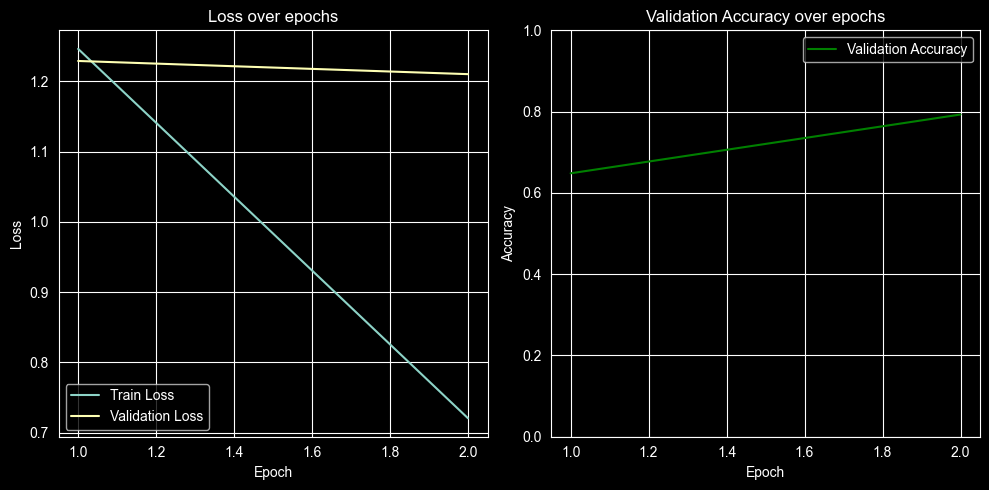

In [4]:
plot_train_hist(hist_train_loss_res, hist_val_loss_res, hist_val_acc_res, epochs = 2)

100%|██████████| 107/107 [07:31<00:00,  4.22s/it]

Test AUC: 0.8838 Test Accuracy: 0.7162


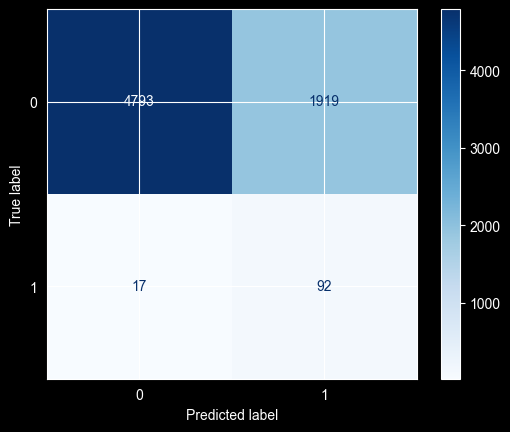

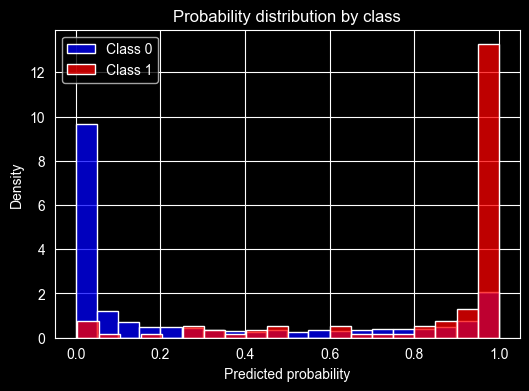

In [5]:
# Load Saved Model
state_dict = torch.load("Best_Resnet101_meta.pt", map_location='mps')
net.load_state_dict(state_dict)

cm_res, ys_res, ps_res, idx_res = evaluate(net, test_loader, device = 'mps', use_meta= True, threshold=0.5)

In [ ]:
# # Load Kaggle Competition Winning Model
# # Find Model Here: https://www.kaggle.com/datasets/boliu0/melanoma-winning-models
# state_dict = torch.load("kaggle_WinningModel.pth", map_location='mps')
# net.load_state_dict(state_dict)
#
# cm_res, ys_res, ps_res, idx_res = evaluate(net, test_loader, device = 'mps', use_meta= True, threshold=0.5)

In [10]:
from Models import Efficientnet_b6

In [11]:
# Set up Model
net = Efficientnet_b6(train_ds.meta.shape[1]).to(device = 'mps')
criterion = nn.BCEWithLogitsLoss() # without weighted loss
opt = torch.optim.AdamW([
    {"params": net.backbone.parameters(), "lr": 1e-5},
    {"params": net.head.parameters(), "lr": 1e-4}
])

# Train only the last layers (freeze the backbone)
for p in net.backbone.parameters():
    p.requires_grad = False
for p in net.backbone.features[-1].parameters():
    p.requires_grad = True
for p in net.head.parameters():
    p.requires_grad = True

hist_train_loss_eff, hist_val_loss_eff, hist_val_acc_eff = train(net, train_loader, val_loader, criterion, opt,
                                                     epochs = 2, best_model_name = "Best_Efficient_net_B6.pt")

100%|██████████| 309/309 [18:53<00:00,  3.67s/it]


Saved new best model at epoch 1 with AUC=0.7844
Epoch 1: Loss Ratio=1.1919, Val AUC=0.7844, Val Pos Acc=0.8175


100%|██████████| 309/309 [20:19<00:00,  3.95s/it]


Epoch 2: Loss Ratio=1.5200, Val AUC=0.7954, Val Pos Acc=0.8467
Best validation pos_acc: 0.8175


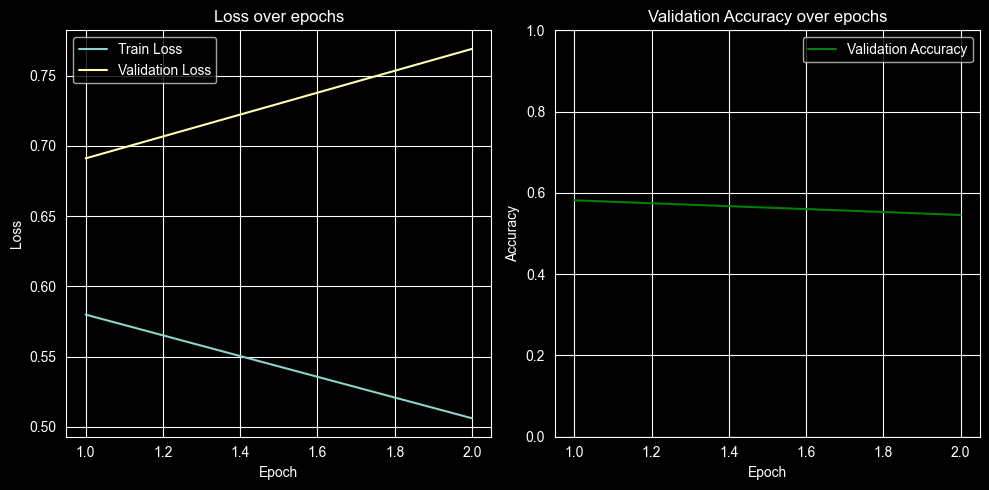

In [12]:
plot_train_hist(hist_train_loss_eff, hist_val_loss_eff, hist_val_acc_eff, epochs = 2)

100%|██████████| 107/107 [04:41<00:00,  2.63s/it]


Test AUC: 0.7850 Test Accuracy: 0.6225


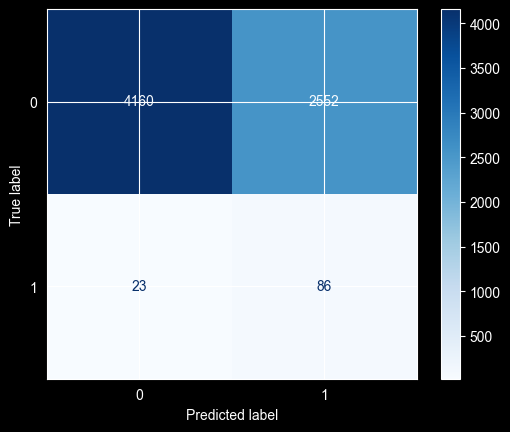

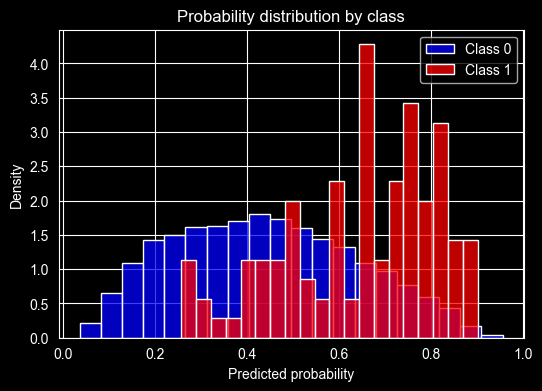

In [13]:
# Load Saved Model
state_dict = torch.load("Best_Efficient_net_B6.pt", map_location='mps')
net.load_state_dict(state_dict)

cm_eff, ys_eff, ps_eff, idx_eff = evaluate(net, test_loader, device = 'mps', use_meta= True, threshold=0.5)

In [17]:
# Set up Model
net = Efficientnet_b6(train_ds.meta.shape[1]).to(device = 'mps')
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight*0.4, dtype=torch.float32).to('mps')) # with weighted loss
opt = torch.optim.AdamW([
    {"params": net.backbone.parameters(), "lr": 1e-5},
    {"params": net.head.parameters(), "lr": 1e-4}
])

# Train only the last layers (freeze the backbone)
for p in net.backbone.parameters():
    p.requires_grad = False
for p in net.backbone.features[-1].parameters():
    p.requires_grad = True
for p in net.head.parameters():
    p.requires_grad = True

hist_train_loss_eff2, hist_val_loss_eff2, hist_val_acc_eff2 = train(net, train_loader, val_loader, criterion, opt,
                                                     epochs = 2, best_model_name = "Best_Efficient_net_B6_2.pt")

100%|██████████| 309/309 [19:10<00:00,  3.72s/it]


Saved new best model at epoch 1 with AUC=0.7273
Epoch 1: Loss Ratio=0.3262, Val AUC=0.7273, Val Pos Acc=0.9562


100%|██████████| 309/309 [17:55<00:00,  3.48s/it]


Epoch 2: Loss Ratio=0.9742, Val AUC=0.7451, Val Pos Acc=0.9854
Best validation pos_acc: 0.9562


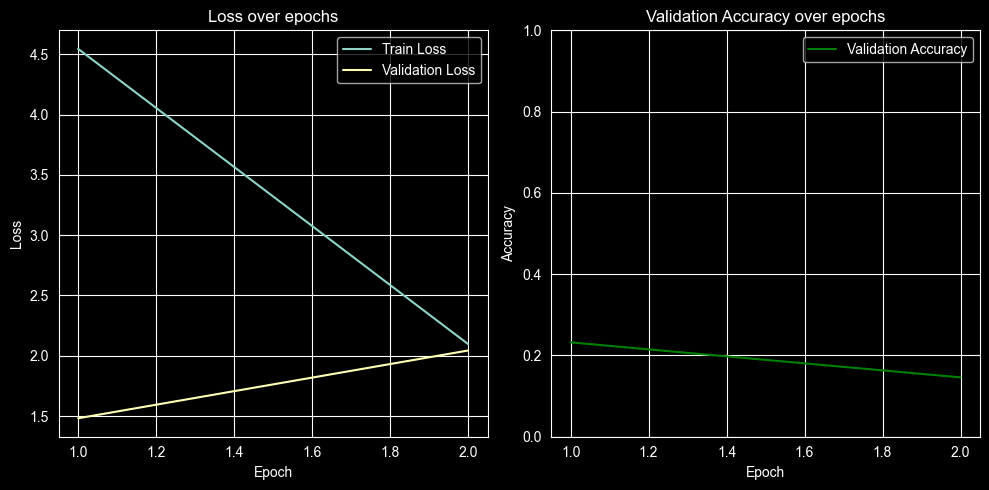

In [18]:
plot_train_hist(hist_train_loss_eff2, hist_val_loss_eff2, hist_val_acc_eff2, epochs = 2)

100%|██████████| 107/107 [03:53<00:00,  2.19s/it]


Test AUC: 0.7595 Test Accuracy: 0.2456


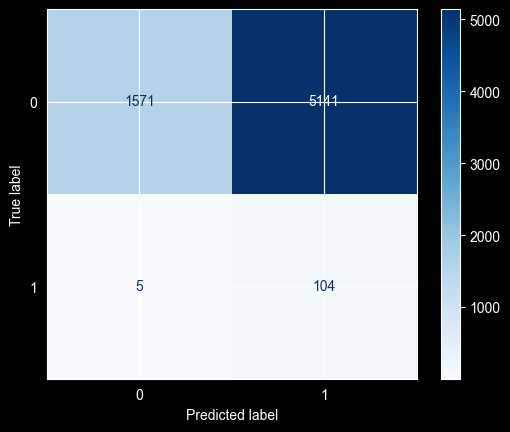

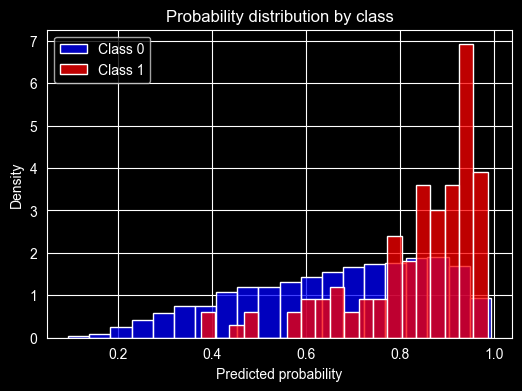

In [19]:
# Load Saved Model
state_dict = torch.load("Best_Efficient_net_B6_2.pt", map_location='mps')
net.load_state_dict(state_dict)

cm_eff2, ys_eff2, ps_eff2, idx_eff2 = evaluate(net, test_loader, device = 'mps', use_meta= True, threshold=0.5)

In [20]:
import numpy as np

In [22]:
np.savez(
    "Evaluation_metrics.npz",

    # EfficientNet2
    hist_train_loss_eff2=hist_train_loss_eff2,
    hist_val_loss_eff2=hist_val_loss_eff2,
    hist_val_acc_eff2=hist_val_acc_eff2,

    # ResNet
    hist_train_loss_res=hist_train_loss_res,
    hist_val_loss_res=hist_val_loss_res,
    hist_val_acc_res=hist_val_acc_res,

    # EfficientNet
    hist_train_loss_eff=hist_train_loss_eff,
    hist_val_loss_eff=hist_val_loss_eff,
    hist_val_acc_eff=hist_val_acc_eff,


    cm_eff2=cm_eff2,
    ys_eff2=ys_eff2,
    ps_eff2=ps_eff2,
    idx_eff2=idx_eff2,


    cm_res=cm_res,
    ys_res=ys_res,
    ps_res=ps_res,
    idx_res=idx_res,

    cm_eff=cm_eff,
    ys_eff=ys_eff,
    ps_eff=ps_eff,
    idx_eff=idx_eff
)

In [ ]:
data = np.load("Evaluation_Metrics.npz", allow_pickle=True)